# Libraries 

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
from statsFuncs import mean_confidence_interval
from statsFuncs import compDistributions
import scipy
import random
import math 
from scipy import stats
mpl.rcParams['axes.linewidth'] = 2

import numpy as np
from scipy.integrate import cumtrapz
from scipy.stats import norm
from matplotlib import pyplot as plt


# Paths 

In [3]:
fig3_path = os.getcwd()
figures_path = str(Path(fig3_path).parent)
datapath = figures_path + '/data/radiologists/Analysis5_22_2020/'

# Plot params 

In [4]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'

# Subject params 

In [5]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

96 files, 15 folders
14 subjects


In [6]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 'SuperSubject']

# Plot histograms 

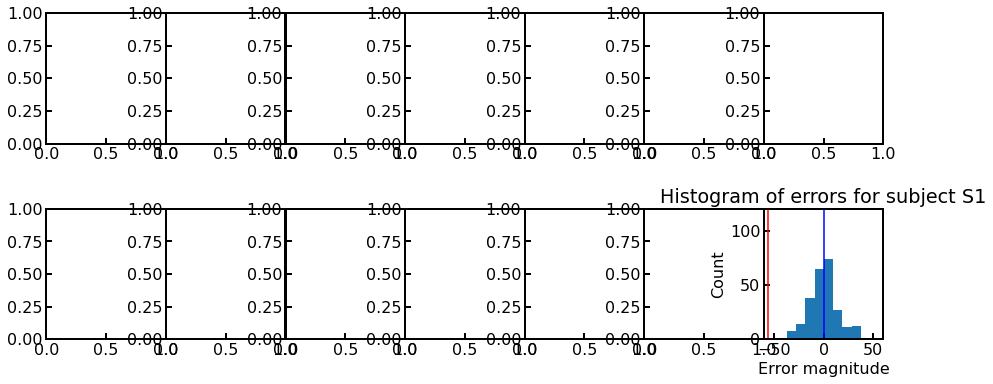

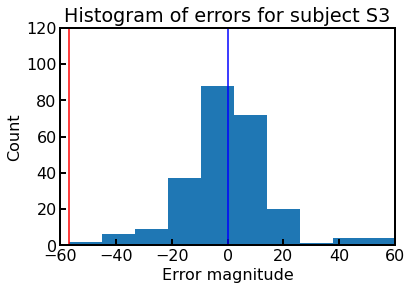

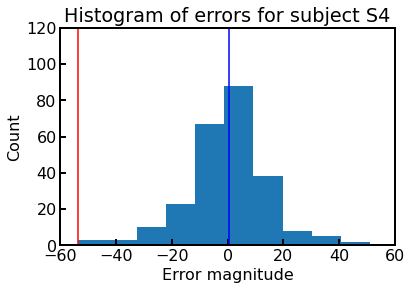

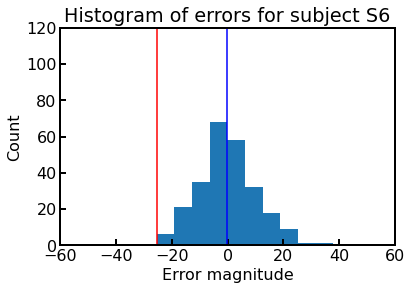

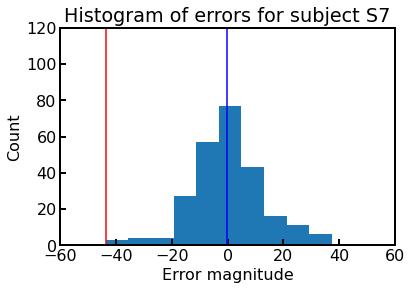

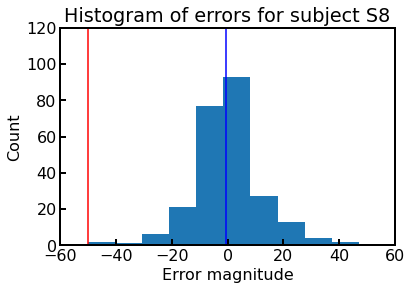

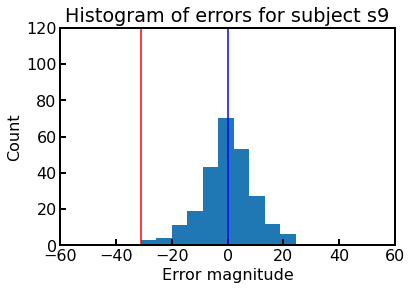

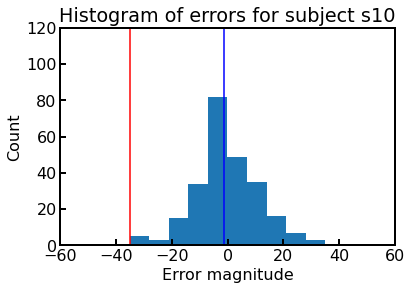

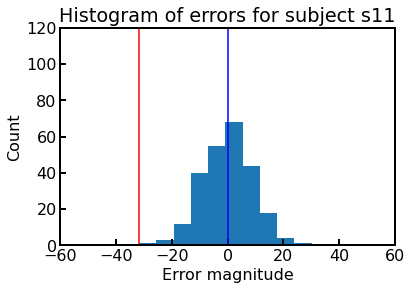

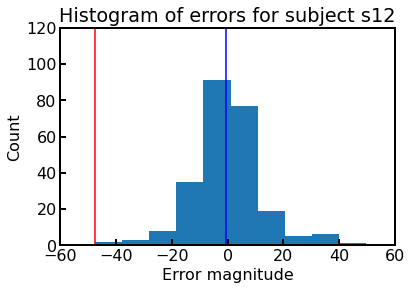

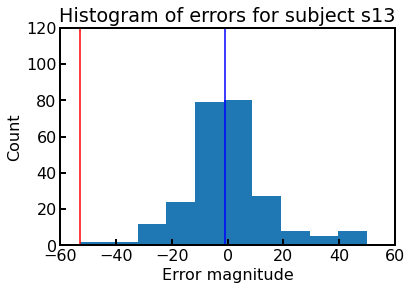

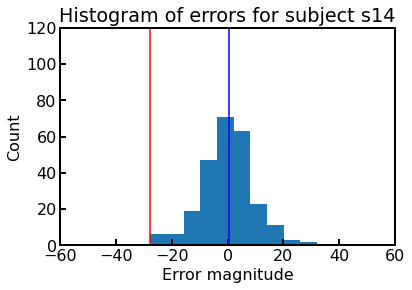

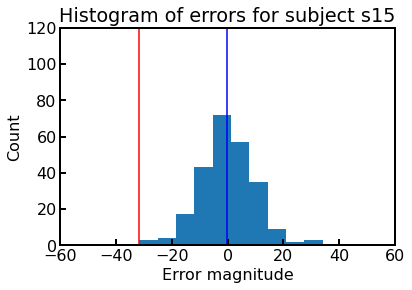

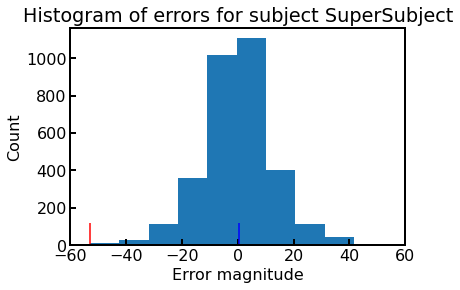

In [7]:
df_percentiles = pd.DataFrame(columns=['SUBJECT','0TH','50TH'])
alldata = pd.DataFrame(columns=['SUBJECT', 'BOOTSTRAP_VALUES'])

row = 0
fig, axs = plt.subplots(2,7, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    df_percentiles.loc[row,'SUBJECT'] = subject
    df_percentiles.loc[row,'0TH'] = np.percentile(np.asarray(subjectdata['responseError'].dropna()), 0)
    df_percentiles.loc[row,'50TH'] = np.percentile(np.asarray(subjectdata['responseError'].dropna()), 50)
    plt.hist(subjectdata['responseError'])
    plt.vlines(df_percentiles.loc[row,'0TH'], 0, 120, color='red')
    plt.vlines(df_percentiles.loc[row,'50TH'], 0, 120, color='blue')
    plt.xlabel('Error magnitude')
    plt.ylabel('Count')
    plt.xlim([-60, 60])
    if subject != 'SuperSubject':
        plt.ylim([0, 120])
    plt.title('Histogram of errors for subject ' + subject)
    plt.show()

    
    row += 1

Text(0.5, 1.0, 'Radiologists\n\n')

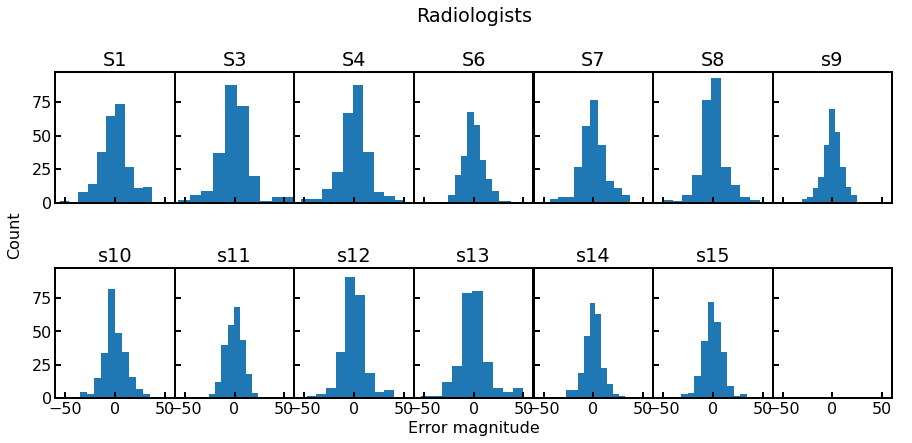

In [8]:
df_percentiles = pd.DataFrame(columns=['SUBJECT','0TH','50TH'])
alldata = pd.DataFrame(columns=['SUBJECT', 'BOOTSTRAP_VALUES'])

row = 0
fig, axs = plt.subplots(2,7, figsize=(15, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.add_subplot(111, frameon=False)

axs = axs.ravel()
subject_names_wsuper = subject_names[:-1]
for subject in subject_names_wsuper:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    df_percentiles.loc[row,'SUBJECT'] = subject
#     df_percentiles.loc[row,'0TH'] = np.percentile(np.asarray(subjectdata['responseError'].dropna()), 0)
#     df_percentiles.loc[row,'50TH'] = np.percentile(np.asarray(subjectdata['responseError'].dropna()), 50)
    axs[row].hist(subjectdata['responseError'])
#     plt.vlines(df_percentiles.loc[row,'0TH'], 0, 120, color='red')
#     plt.vlines(df_percentiles.loc[row,'50TH'], 0, 120, color='blue')
    axs[row].set_xlabel('')
    axs[row].set_ylabel('')
    axs[row].set_xlim([-60, 60])
#     if subject != 'SuperSubject':
#         plt.ylim([0, 120])
    axs[row].set_title(subject)
#     plt.show()


    row += 1
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Error magnitude')
plt.ylabel('Count')
plt.title('Radiologists\n\n')

In [9]:
df_percentiles['DIFFERENCE'] = df_percentiles['50TH'] - df_percentiles['0TH']

In [10]:
df_percentiles

,SUBJECT,0TH,50TH,DIFFERENCE
0,S1,NaN,NaN,NaN
1,S3,NaN,NaN,NaN
2,S4,NaN,NaN,NaN
3,S6,NaN,NaN,NaN
4,S7,NaN,NaN,NaN
5,S8,NaN,NaN,NaN
6,s9,NaN,NaN,NaN
7,s10,NaN,NaN,NaN
8,s11,NaN,NaN,NaN
9,s12,NaN,NaN,NaN


Text(0.5, 1.0, '50th-0th percentile of response error per subject + supersubject')

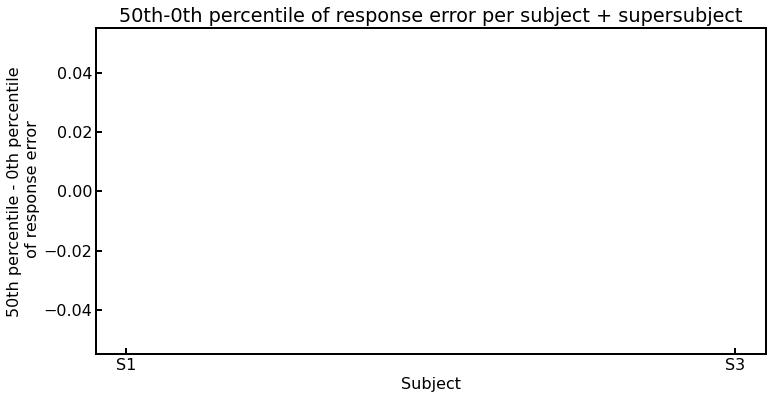

In [11]:
plt.figure(figsize=(12,6))
plt.bar(df_percentiles['SUBJECT'],  df_percentiles['DIFFERENCE'], color='gray')
plt.ylabel('50th percentile - 0th percentile\n of response error')
plt.xlabel('Subject')
plt.title('50th-0th percentile of response error per subject + supersubject')

# New JND calculation 

In [12]:
alldata = pd.DataFrame()
row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    alldata[subject] = subjectdata.loc[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84), 'responseError']

    
    row += 1

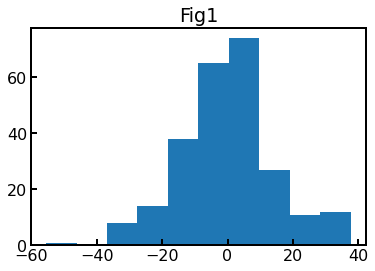

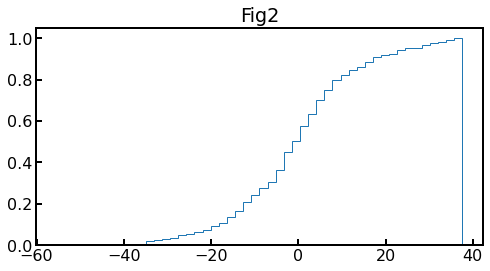

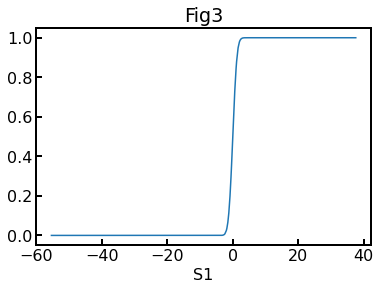

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


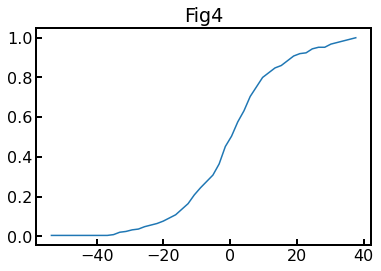

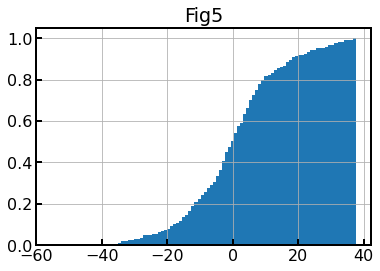

In [13]:
n_bins = 50
plt.hist(alldata['S1'])
plt.title('Fig1')
plt.show()
fig, ax = plt.subplots(figsize=(8, 4))

n, bins, patches = ax.hist(alldata['S1'], n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical')
plt.title('Fig2')

plt.show()

norm_cdf = scipy.stats.norm.cdf(alldata['S1']) # calculate the cdf - also discrete

# plot the cdf
sns.lineplot(x=alldata['S1'], y=norm_cdf)
plt.title('Fig3')

plt.show()

counts, bin_edges = np.histogram (alldata['S1'], bins=n_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
plt.title('Fig4')

plt.show()
alldata['S1'].hist(cumulative=True, density=1, bins=100)
plt.title('Fig5')

plt.show()

In [14]:
n

array([0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.008, 0.02 , 0.024, 0.032, 0.036, 0.048, 0.056, 0.064,
       0.076, 0.092, 0.108, 0.136, 0.164, 0.208, 0.244, 0.276, 0.308,
       0.364, 0.452, 0.504, 0.576, 0.632, 0.704, 0.752, 0.8  , 0.824,
       0.848, 0.86 , 0.884, 0.908, 0.92 , 0.924, 0.944, 0.952, 0.952,
       0.968, 0.976, 0.984, 0.992, 1.   ])

In [15]:
cdf

array([0.00215016, 0.00215016, 0.00215016, 0.00215016, 0.00215016,
       0.00215016, 0.00215016, 0.00215016, 0.00215016, 0.00215016,
       0.00430031, 0.01075078, 0.01290093, 0.01720125, 0.0193514 ,
       0.02580187, 0.03010218, 0.03440249, 0.04085296, 0.04945358,
       0.0580542 , 0.07310529, 0.08815638, 0.1118081 , 0.1311595 ,
       0.14836074, 0.16556199, 0.19566417, 0.2429676 , 0.27091962,
       0.30962242, 0.3397246 , 0.37842741, 0.40422927, 0.43003114,
       0.44293208, 0.45583301, 0.46228348, 0.47518441, 0.48808535,
       0.49453581, 0.49668597, 0.50743675, 0.51173706, 0.51173706,
       0.52033768, 0.52463799, 0.52893831, 0.53323862, 0.53753893])

In [16]:
cdf = alldata['S1'].value_counts().sort_index().cumsum() / alldata['S1'].shape[0]
cdf

-55.422080    0.004
-35.363278    0.008
-34.506615    0.012
-33.413124    0.016
-33.355329    0.020
              ...  
 33.012205    0.984
 33.897536    0.988
 34.473975    0.992
 36.877072    0.996
 37.594439    1.000
Name: S1, Length: 247, dtype: float64

In [17]:
first_line = np.percentile(np.sort(cdf.index), 25) 
second_line = np.percentile(np.sort(cdf.index), 75) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


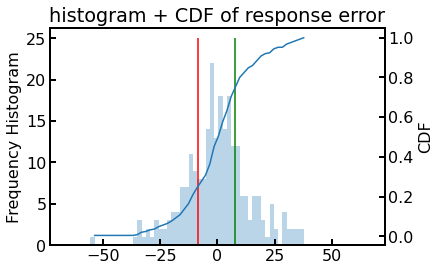

In [18]:
fig,ax = plt.subplots()
ax.hist(alldata['S1'], alpha=0.3, bins=50)
ax.set_xlim([-73, 73])
ax.set_ylabel('Frequency Histogram')
ax.vlines(first_line, 0, 25, color='red')
ax.vlines(second_line, 0, 25, color='green')

ax2=ax.twinx()

counts, bin_edges = np.histogram (alldata['S1'], bins=n_bins, normed=True)
cdf = np.cumsum (counts)
ax2.plot (bin_edges[1:], cdf/cdf[-1])
ax2.set_title('histogram + CDF of response error')
ax2.set_xlim([-73, 73])
ax2.set_ylabel('CDF')
plt.xlabel('Respose Error')
plt.show()

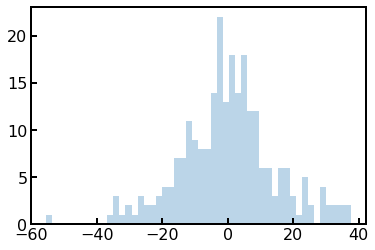

In [19]:
fig,ax = plt.subplots()
c, a, _ = ax.hist(alldata['S1'], alpha=0.3, bins=50)

In [20]:
c_filtered = c
c_filtered[c_filtered < 4] = 0

In [21]:
c_filtered

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  4.,  4.,  7.,  7., 11.,  9.,  8.,
        8., 14., 22., 13., 18., 14., 18., 12., 12.,  6.,  6.,  0.,  6.,
        6.,  0.,  0.,  5.,  0.,  0.,  4.,  0.,  0.,  0.,  0.])

In [22]:
cdf_filtered = np.cumsum(c_filtered)

In [23]:
final_cdf_filtered = cdf_filtered/cdf_filtered[-1]

In [24]:
plt.scatter(bin_edges[1:], final_cdf_norm, color='blue')
plt.scatter(bin_edges[1:], final_cdf, color='red')

NameError: name 'final_cdf_norm' is not defined

[-0.98079758 -0.10175437  7.50215441  0.98630736]


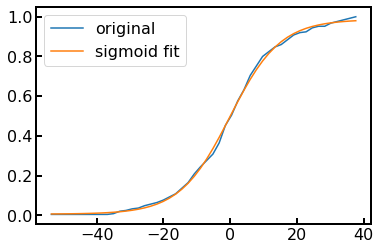

In [30]:
from scipy.optimize import curve_fit

# def sigmoid(x, x0, k):
#     y = 1 / (1 + np.exp(-k*(x-x0)))
#     return y
def sigmoid (x, A, h, slope, C):
    return 1 / (1 + np.exp ((x - h) / slope)) *  A + C
# Fits the function sigmoid with the x and y data
#   Note, we are using the cumulative sum of your beta distribution!
p, _ = curve_fit(sigmoid, bin_edges[1:], final_cdf)

# Plots the data
plt.plot(bin_edges[1:], final_cdf, label='original')
plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], *p), label='sigmoid fit')
plt.legend()

# Show parameters for the fit
print(p)

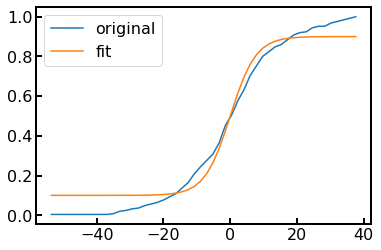

In [31]:
def sigmoid(x,a):
    return 0.8/(1+np.exp(-a*x)) + 0.1

bestvals, temp = curve_fit(sigmoid,bin_edges[1:],final_cdf_filtered,p0=[4])
bestvals

plt.plot(bin_edges[1:], final_cdf, label='original')
plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals), label='fit')
plt.legend()
plt.show()
# bin_edges[1:]

In [32]:
import math

bestvals, temp = curve_fit(sigmoid,bin_edges[1:],final_cdf_filtered,p0=[4])
bestvals

def inverse_sigmoid(y, a):
    return -math.log(0.8/(y-0.1)-1)/a

inverse_sigmoid(0.25, bestvals)

array([-5.61813852])

In [33]:
sigmoid(bin_edges[1:], bestvals)

array([0.10000068, 0.1000011 , 0.10000179, 0.10000291, 0.10000473,
       0.10000769, 0.1000125 , 0.10002032, 0.10003302, 0.10005366,
       0.10008719, 0.10014168, 0.10023021, 0.10037404, 0.10060766,
       0.10098703, 0.10160274, 0.1026013 , 0.10421871, 0.10683315,
       0.11104534, 0.1177958 , 0.12852272, 0.1453408 , 0.17116075,
       0.20954981, 0.26398889, 0.33622506, 0.42406774, 0.52022758,
       0.61409921, 0.69603008, 0.76083752, 0.80822428, 0.84091781,
       0.86258019, 0.87655146, 0.88540616, 0.89095607, 0.89441042,
       0.89655113, 0.89787417, 0.89869051, 0.89919369, 0.89950363,
       0.89969448, 0.89981197, 0.89988428, 0.89992879, 0.89995618])

In [29]:
final_cdf

array([0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.008, 0.02 , 0.024, 0.032, 0.036, 0.048, 0.056, 0.064,
       0.076, 0.092, 0.108, 0.136, 0.164, 0.208, 0.244, 0.276, 0.308,
       0.364, 0.452, 0.504, 0.576, 0.632, 0.704, 0.752, 0.8  , 0.824,
       0.848, 0.86 , 0.884, 0.908, 0.92 , 0.924, 0.944, 0.952, 0.952,
       0.968, 0.976, 0.984, 0.992, 1.   ])

In [28]:
counts, bin_edges = np.histogram (alldata['S1'], bins=n_bins, normed=True)
cdf = np.cumsum (counts)
final_cdf = cdf/cdf[-1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


In [ ]:
plt.hist(alldata['S1'])

In [ ]:
n_bins

In [ ]:
counts

In [ ]:
test_data = np.asarray(alldata['S1'])
test_data[test_]

In [ ]:
final_cdf

## Subject loop with new JND

In [34]:
def calculate_and_plot_cdf(data, title):
    counts, bin_edges = np.histogram (data, bins=n_bins, normed=True)
    cdf = np.cumsum (counts)
    cdf_values = data.value_counts().sort_index().cumsum() / data.shape[0]
    print(cdf_values)
    cdf_percentile_25 = np.percentile(np.sort(cdf_values.index), 25) 
    cdf_percentile_75 = np.percentile(np.sort(cdf_values.index), 75) 
    
    fig,ax = plt.subplots()
    ax.hist(data, alpha=0.5, bins=50, color='lightblue')
    ax.set_xlim([-73, 73])
    ax.set_ylabel('Frequency Histogram')
    ax.vlines(cdf_percentile_25, 0, 25, color='red')
    ax.vlines(cdf_percentile_75, 0, 25, color='green')

    ax2=ax.twinx()


    ax2.plot (bin_edges[1:], cdf/cdf[-1], color='black', linewidth=2.5)
    ax2.set_title('histogram + CDF of response error\n Subject: ' + title)
    ax2.set_xlim([-73, 73])
    ax2.set_ylabel('CDF')
    plt.xlabel('Respose Error')
    plt.show()
#     print(bin_edges)
#     print(cdf_values.index)
    return cdf_values, cdf_percentile_25, cdf_percentile_75

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-55.422080    0.004
-35.363278    0.008
-34.506615    0.012
-33.413124    0.016
-33.355329    0.020
              ...  
 33.012205    0.984
 33.897536    0.988
 34.473975    0.992
 36.877072    0.996
 37.594439    1.000
Name: responseError, Length: 247, dtype: float64


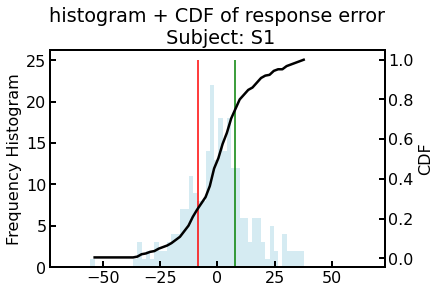

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-56.938985    0.004115
-51.997591    0.008230
-44.408201    0.012346
-42.991311    0.016461
-40.204022    0.020576
                ...   
 48.098394    0.983539
 51.933738    0.987654
 54.045569    0.991770
 56.314648    0.995885
 61.380379    1.000000
Name: responseError, Length: 239, dtype: float64


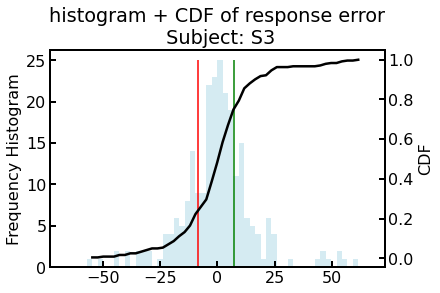

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-53.480202    0.004049
-47.756784    0.008097
-45.837405    0.012146
-38.020704    0.016194
-36.542805    0.020243
                ...   
 33.635427    0.983806
 35.357888    0.987854
 39.125196    0.991903
 44.118616    0.995951
 51.118616    1.000000
Name: responseError, Length: 243, dtype: float64


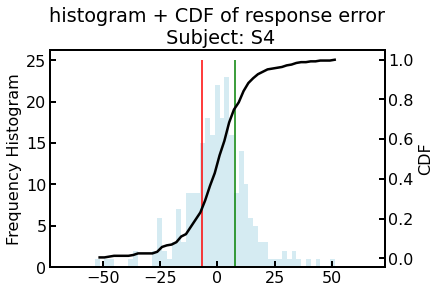

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-25.378196    0.004016
-23.906509    0.008032
-22.274469    0.012048
-21.919862    0.016064
-20.038303    0.020080
                ...   
 22.780620    0.983936
 22.844169    0.987952
 24.901059    0.991968
 26.435166    0.995984
 37.811531    1.000000
Name: responseError, Length: 243, dtype: float64


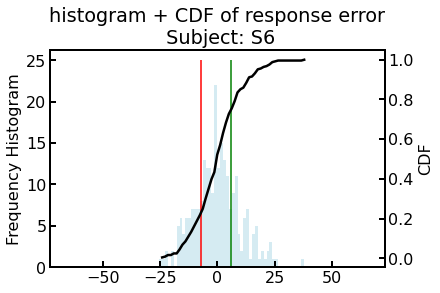

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-43.626598    0.004032
-43.330480    0.008065
-38.190012    0.012097
-31.796400    0.016129
-29.031638    0.020161
                ...   
 30.155105    0.983871
 32.163856    0.987903
 33.687901    0.991935
 35.284882    0.995968
 37.342362    1.000000
Name: responseError, Length: 246, dtype: float64


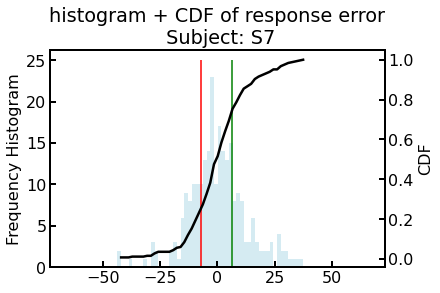

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-50.030450    0.004065
-43.286294    0.008130
-33.053756    0.012195
-30.053756    0.016260
-28.794480    0.020325
                ...   
 30.909209    0.983740
 34.047810    0.987805
 37.277035    0.991870
 37.341496    0.995935
 47.009044    1.000000
Name: responseError, Length: 240, dtype: float64


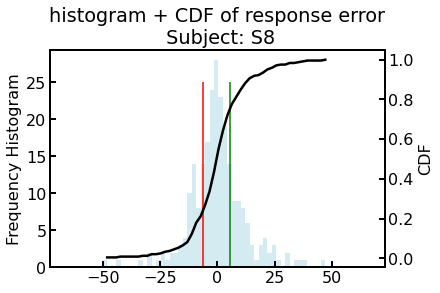

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-31.069045    0.004032
-27.322263    0.008065
-27.174489    0.012097
-23.280764    0.016129
-21.765192    0.020161
                ...   
 20.131852    0.983871
 22.564257    0.987903
 23.374367    0.991935
 23.849170    0.995968
 24.377390    1.000000
Name: responseError, Length: 245, dtype: float64


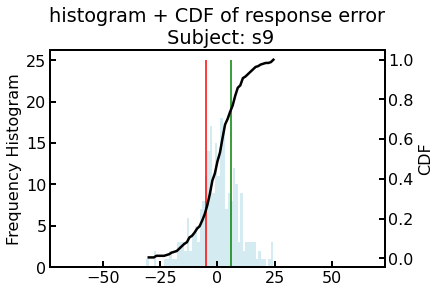

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-35.110646    0.004016
-33.441823    0.008032
-30.011875    0.012048
-28.482783    0.016064
-28.125461    0.020080
                ...   
 25.781342    0.983936
 27.492434    0.987952
 29.804841    0.991968
 32.345982    0.995984
 35.009332    1.000000
Name: responseError, Length: 247, dtype: float64


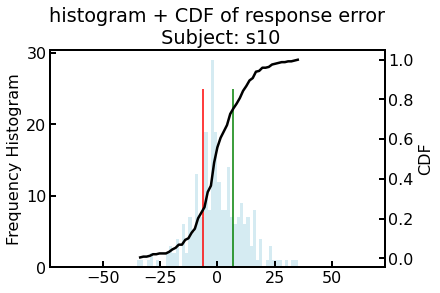

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-31.759483    0.004065
-22.776480    0.008130
-22.534022    0.012195
-20.956791    0.016260
-17.833167    0.020325
                ...   
 18.223520    0.983740
 18.796045    0.987805
 20.318836    0.991870
 23.753823    0.995935
 30.107082    1.000000
Name: responseError, Length: 238, dtype: float64


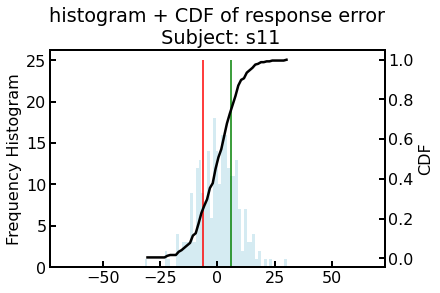

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-47.661598    0.004049
-45.401729    0.008097
-37.443261    0.012146
-36.834658    0.016194
-31.986442    0.020243
                ...   
 34.477627    0.983806
 37.281224    0.987854
 38.503049    0.991903
 39.280015    0.995951
 49.756415    1.000000
Name: responseError, Length: 245, dtype: float64


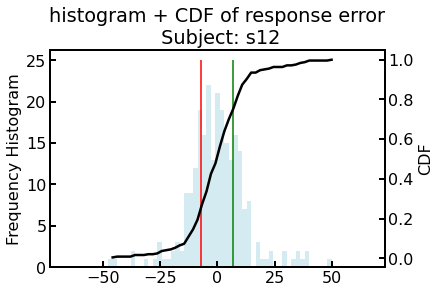

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-52.760577    0.004049
-48.342759    0.008097
-37.980176    0.012146
-33.157418    0.016194
-31.228004    0.020243
                ...   
 45.509119    0.983806
 46.556573    0.987854
 49.145122    0.991903
 49.646653    0.995951
 49.918081    1.000000
Name: responseError, Length: 246, dtype: float64


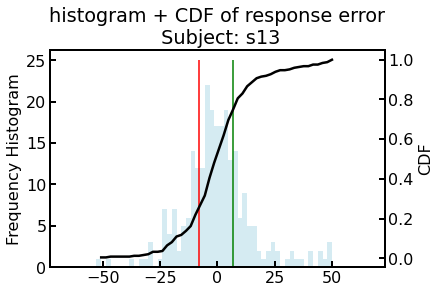

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-27.650774    0.003984
-26.986684    0.007968
-26.547455    0.011952
-22.862040    0.015936
-22.668335    0.019920
                ...   
 20.481589    0.984064
 21.541539    0.988048
 24.011284    0.992032
 26.697329    0.996016
 32.019272    1.000000
Name: responseError, Length: 247, dtype: float64


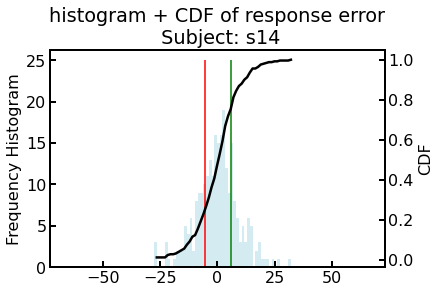

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-31.663909    0.004082
-29.904570    0.008163
-28.435451    0.012245
-24.141551    0.016327
-23.267018    0.020408
                ...   
 18.727677    0.979592
 22.428909    0.987755
 28.336091    0.991837
 31.787647    0.995918
 34.054756    1.000000
Name: responseError, Length: 238, dtype: float64


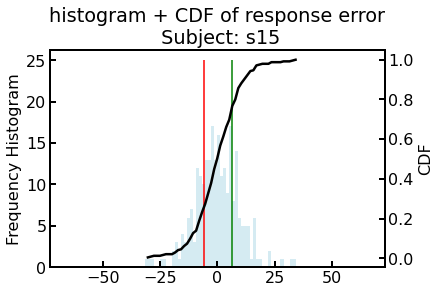

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-52.974024    0.000312
-50.268412    0.000624
-48.735944    0.000936
-46.980999    0.001248
-46.971263    0.001560
                ...   
 43.795603    0.998752
 45.264065    0.999064
 48.264065    0.999376
 49.892916    0.999688
 52.264065    1.000000
Name: responseError, Length: 2431, dtype: float64


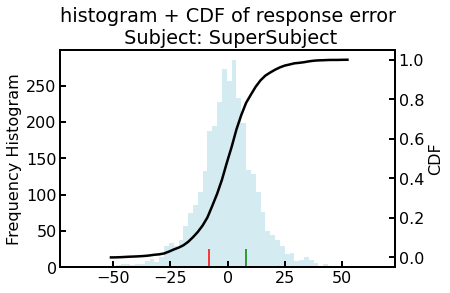

In [35]:
cdf_data = pd.DataFrame(columns=['SUBJECT','0TH','50TH'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

    cdf, cdf_percentile_25, cdf_percentile_75 = calculate_and_plot_cdf(subjectdata['responseError'], title=subject)
    cdf_data.loc[row,'SUBJECT'] = subject
    cdf_data.loc[row, 'JND_CR'] = (cdf_percentile_75- cdf_percentile_25)/2
    
    
    row += 1

Text(0.5, 1.0, 'Continuous Report Discrimination (CRD) per subject')

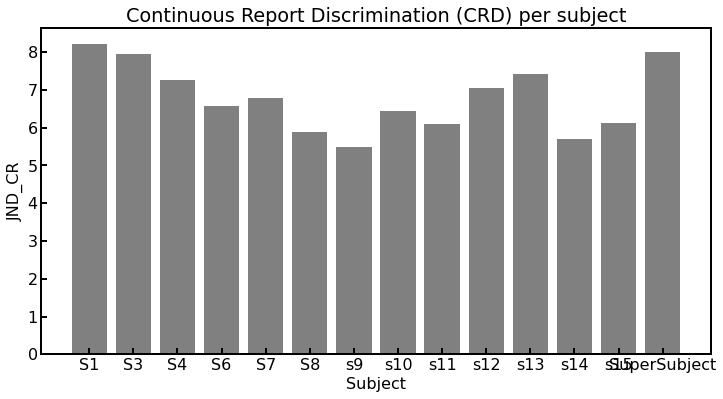

In [36]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_CR'], color='gray')
plt.ylabel('JND_CR')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) per subject')

In [37]:
cdf.index

Float64Index([ -52.97402422811504, -50.268411921528006, -48.735944467722696,
               -46.98099878281186,  -46.97126274826624,  -46.14450572723396,
                -45.0018409603509,  -44.88172051087496,  -44.40289568305794,
               -44.07626786535475,
              ...
               41.025975771884966,   41.31694505261641,   42.31070468207519,
               42.459176010378265,   42.98438096425392,   43.79560261483349,
                45.26406492918361,   48.26406492918361,   49.89291626307702,
                52.26406492918361],
             dtype='float64', length=2431)

## Steeper function 

In [94]:
def sigmoid(x,a):
    return 0.8/(1+np.exp(-a*x)) + 0.1

bestvals, temp = curve_fit(sigmoid,bin_edges[1:],final_cdf_filtered,p0=[4])
bestvals

def inverse_sigmoid(y, a):
    return -math.log(0.8/(y-0.1)-1)/a

inverse_sigmoid(0.25, bestvals)
def calculate_and_plot_cdf(data, title):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    counts_filtered = counts.copy()
    counts_filtered[counts_filtered < 5] = 0
    cdf_filtered = np.cumsum (counts_filtered)
    c = cdf_filtered.copy()
    cdf_filtered = cdf_filtered/cdf_filtered[-1]
    
    cdf = np.cumsum (counts)
    cdf = cdf/cdf[-1]
    
    bestvals, temp = curve_fit(sigmoid,bin_edges[1:],cdf_filtered,p0=[5])

    perc_25 = inverse_sigmoid(0.25, bestvals)
    perc_75 = inverse_sigmoid(0.75, bestvals)
    
    plt.plot(bin_edges[1:], cdf, color='red', linewidth=1.5, label='original')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals), color='blue', linewidth=2.5,label='filtered')
    plt.xlim([-60, 40])
    plt.ylabel('CDF')
    plt.xlabel('Response Error')
    plt.legend()
    plt.title(title)
    plt.show()
    
    return (perc_75 - perc_25)/2
#     ax2.plot (bin_edges[1:], cdf/cdf[-1], color='black', linewidth=2.5)
#     ax2.set_title('histogram + CDF of response error\n Subject: ' + title)
#     ax2.set_xlim([-73, 73])
#     ax2.set_ylabel('CDF')
#     plt.xlabel('Respose Error')
#     plt.show()
# #     print(bin_edges)
# #     print(cdf_values.index)
#     return cdf_values, cdf_percentile_25, cdf_percentile_75

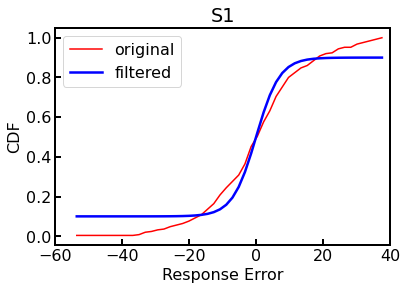

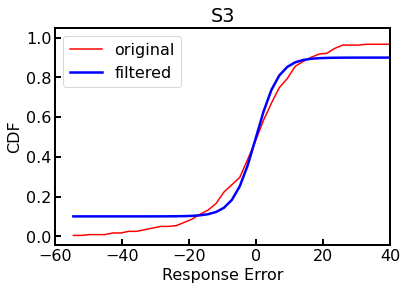

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


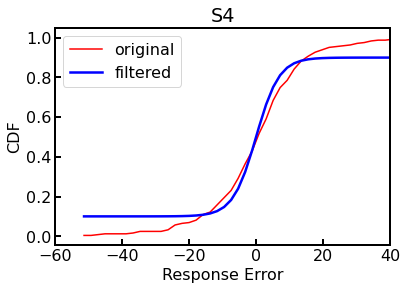

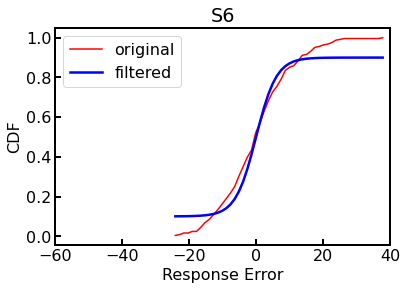

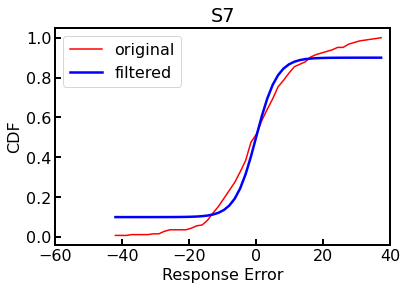

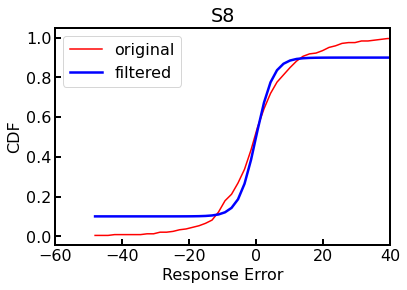

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


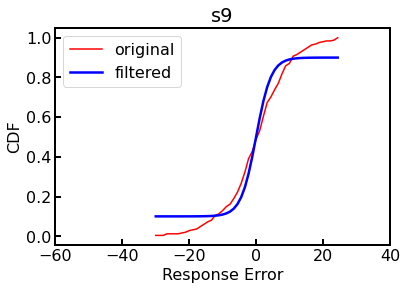

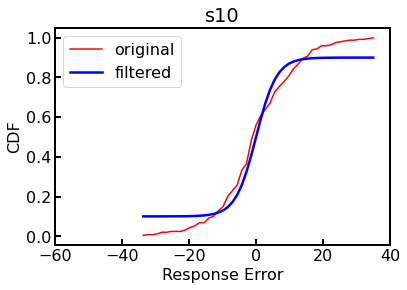

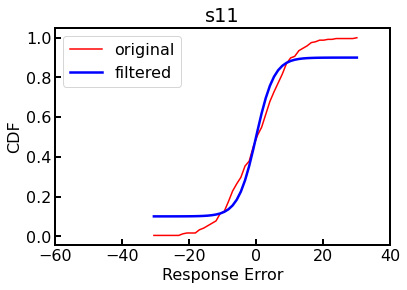

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


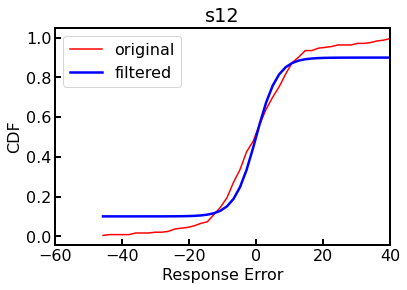

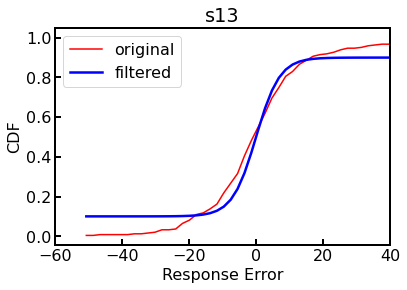

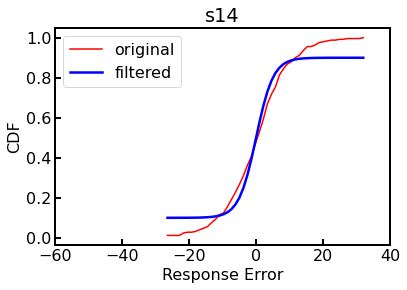

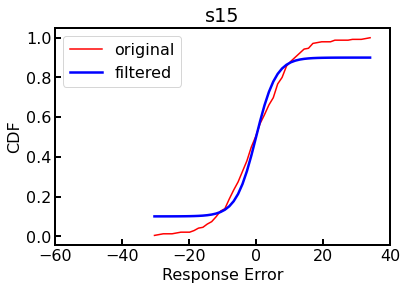

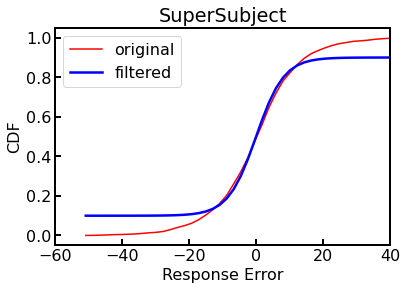

In [95]:
cdf_data = pd.DataFrame(columns=['SUBJECT','JND_CR'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

#     cdf_filtered_sub = calculate_and_plot_cdf(subjectdata['responseError'], title=subject)
    
    jnd_cr = calculate_and_plot_cdf(subjectdata['responseError'], title=subject)
    cdf_data.loc[row,'SUBJECT'] = subject
    cdf_data.loc[row, 'JND_CR'] = jnd_cr[0]
    
    
    row += 1

In [96]:
cdf_data

,SUBJECT,JND_CR
0,S1,5.146075
1,S3,4.921389
2,S4,5.059302
3,S6,4.469861
4,S7,4.597411
5,S8,3.741497
6,s9,3.287051
7,s10,4.462661
8,s11,3.947852
9,s12,4.728421


Text(0.5, 1.0, 'Continuous Report Discrimination (CRD) v2 per subject')

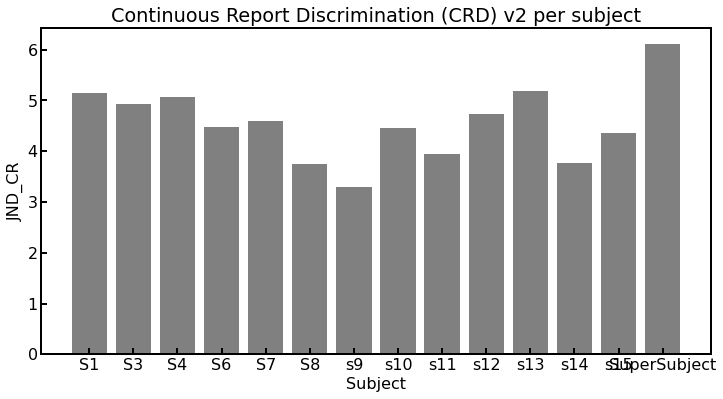

In [41]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_CR'], color='gray')
plt.ylabel('JND_CR')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) v2 per subject')

# Gaussian & Cauchy distribution 

In [42]:
data = np.asarray(alldata['S1'])
counts, bin_edges = np.histogram(data, bins=n_bins)

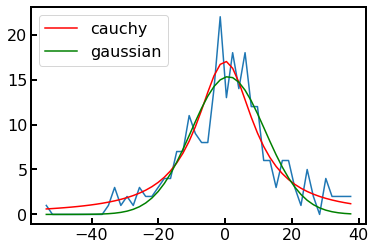

In [74]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)
def cauchy(x, gamma, amplitude):
    return (1/(np.pi*gamma*(1+(x/gamma)**2)))*amplitude
    
popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) #, p0=4, bounds= (0,np.inf))
popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
plt.plot(bin_edges[1:], counts)
plt.plot(bin_edges[1:], cauchy(bin_edges[1:], *popt_cauchy), color='red', label='cauchy')
plt.plot(bin_edges[1:], gaussian(bin_edges[1:], *popt_gaussian), color='green', label='gaussian')
plt.legend()

In [126]:
def sigmoid(x,a):
    return 0.8/(1+np.exp(-a*x)) + 0.1

def inverse_sigmoid(y, a):
    return -math.log(0.8/(y-0.1)-1)/a

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x-mean)**2/(2*stddev**2))

def cauchy(x, gamma, amplitude, mean):
    return (1/(np.pi*gamma*(1+((x-mean)/gamma)**2)))*amplitude

def cdf(counts):
    cdf = np.cumsum (counts)
    cdf = cdf/cdf[-1]
    
    counts_filtered = counts.copy()
    counts_filtered[counts_filtered < 5] = 0
    cdf_filtered = np.cumsum (counts_filtered)
    c = cdf_filtered.copy()
    cdf_filtered = cdf_filtered/cdf_filtered[-1]
    

        
    
    return cdf, cdf_filtered, counts_filtered
    
def cdf_gaussian_cauchy(data, title):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    
    if title=='SuperSubject':
        counts = counts/13
    
    cdf_og, cdf_filtered_og, counts_filtered_og = cdf(counts)
    
    popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) #, p0=4, bounds= (0,np.inf))
    popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
    
    counts_cauchy = cauchy(bin_edges[1:], *popt_cauchy)
    print(popt_gaussian)
    counts_gaussian = gaussian(bin_edges[1:], *popt_gaussian)
    
    cdf_cauchy, cdf_filtered_cauchy, counts_cauchy_filtered = cdf(counts_cauchy)
    cdf_gaussian, cdf_filtered_gaussian, counts_gaussian_filtered = cdf(counts_gaussian)
    
    bestvals_og, temp_og = curve_fit(sigmoid,bin_edges[1:],cdf_og,p0=[5])
    bestvals_cauchy, temp_cauchy = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_cauchy,p0=[5])
    bestvals_gaussian, temp_gaussian = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_gaussian,p0=[5])
    
    perc_25_og = inverse_sigmoid(0.25, bestvals_og)
    perc_75_og = inverse_sigmoid(0.75, bestvals_og)
        
    perc_25_cauchy = inverse_sigmoid(0.25, bestvals_cauchy)
    perc_75_cauchy = inverse_sigmoid(0.75, bestvals_cauchy)
    
    perc_25_gaussian = inverse_sigmoid(0.25, bestvals_gaussian)
    perc_75_gaussian = inverse_sigmoid(0.75, bestvals_gaussian)
    
    plt.plot(bin_edges[1:], cdf_og, color='red', linewidth=1.5, label='original')
#     plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_og), color='red', linewidth=1.5, label='original')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_cauchy), color='blue', linewidth=2.5,label='cauchy')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_gaussian), color='green', linewidth=2.5,label='gaussian')
    plt.xlim([-60, 40])
    plt.ylabel('CDF')
    plt.xlabel('Response Error')
    plt.legend()
    plt.title(title)
    plt.show()
    
    return (perc_75_og - perc_25_og)/2, (perc_75_gaussian - perc_25_gaussian)/2, (perc_75_cauchy - perc_25_cauchy)/2


[15.33203567  0.93160543 11.0798342 ]


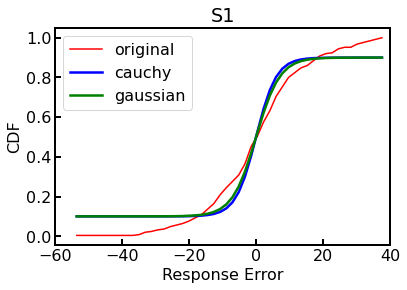

[21.36926656  1.65820228  9.41284972]


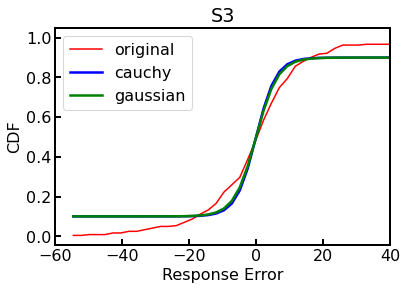

[19.29925665  1.77257697  9.74036132]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


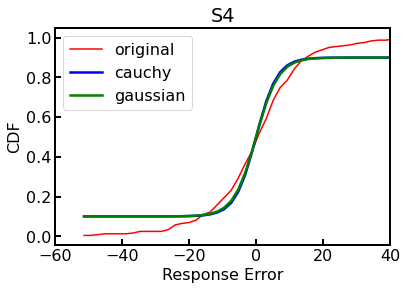

[13.1885378  -0.05674133  9.22245668]


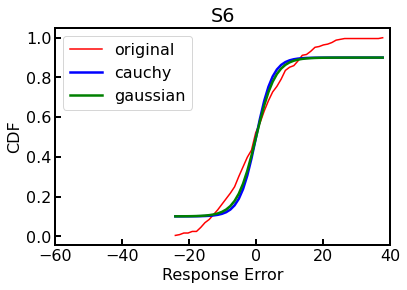

[15.48123583 -0.11366588  9.54957061]


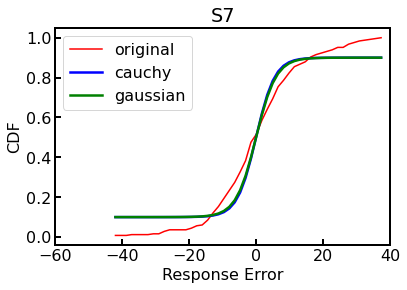

[22.48588985  0.26853356  7.51081689]


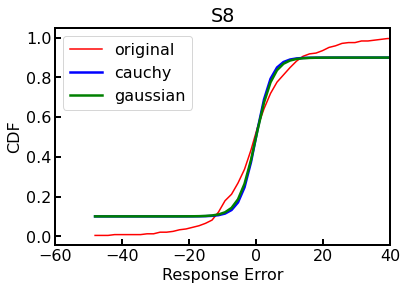

[13.61204169  0.99541922  7.56160754]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


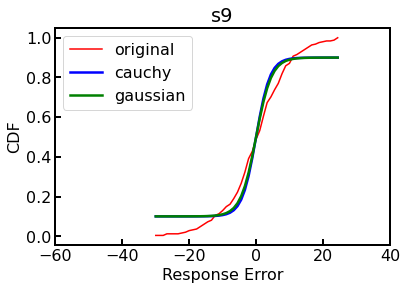

[14.34834497 -0.09094864  9.07069941]


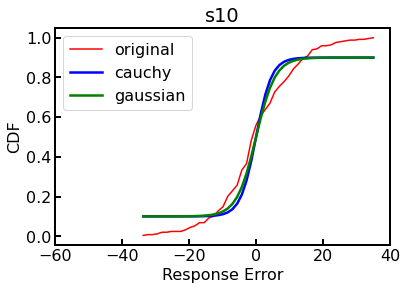

[13.98536503  0.96457764 -8.66471598]


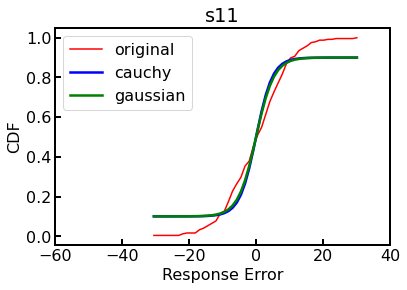

[19.46805683  0.32767546  9.35380417]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


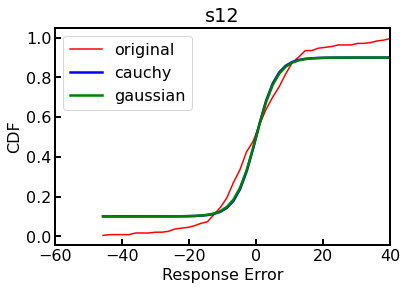

[18.26219694  0.04057479  9.89396408]


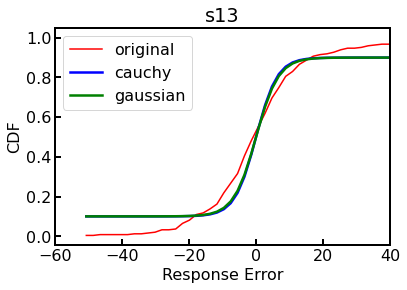

[14.67006277  0.90802979  7.70254993]


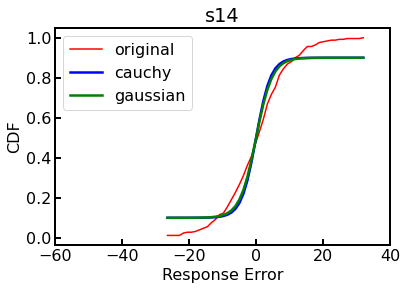

[14.32230025  0.61462919  8.79449809]


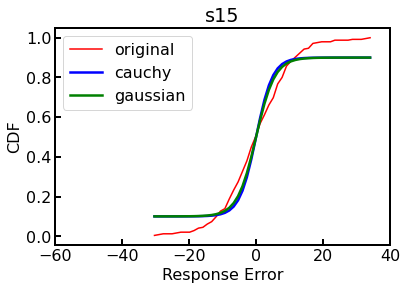

[19.65475066  1.29796338  9.84085277]


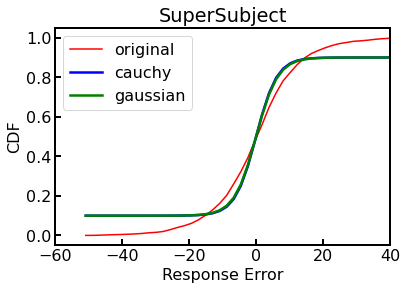

In [127]:
cdf_data = pd.DataFrame(columns=['SUBJECT','JND_OG',  'JND_GAUSSIAN', 'JND_CAUCHY'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

    jnd_og, jnd_gaussian, jnd_cauchy = cdf_gaussian_cauchy(subjectdata['responseError'], title=subject)
    
    cdf_data.loc[row,'SUBJECT'] = subject
    cdf_data.loc[row, 'JND_OG'] = jnd_og[0]
    cdf_data.loc[row, 'JND_GAUSSIAN'] = jnd_gaussian[0]
    cdf_data.loc[row, 'JND_CAUCHY'] = jnd_cauchy[0]
    
    row += 1

In [125]:
subject_names

['S1',
 'S3',
 'S4',
 'S6',
 'S7',
 'S8',
 's9',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 'SuperSubject']

In [122]:
subjectdata['responseError']

0       12.899911
1       19.925233
2        4.903950
3       20.953967
4        3.376916
          ...    
3238     6.468113
3239     2.795603
3240    -0.974024
3241     8.117835
3242     3.161745
Name: responseError, Length: 3206, dtype: float64

In [128]:
cdf_data

,SUBJECT,JND_OG,JND_GAUSSIAN,JND_CAUCHY
0,S1,7.226945,5.200871,4.440281
1,S3,6.644665,4.771759,4.373640
2,S4,6.450299,4.900141,4.598201
3,S6,5.497745,4.224424,3.629814
4,S7,6.227108,4.381820,4.106948
5,S8,5.197493,3.741061,3.380932
6,s9,4.759932,3.388883,3.043517
7,s10,5.758750,4.207363,3.391882
8,s11,4.999229,3.938625,3.590567
9,s12,5.874611,4.635955,4.450145


(0.0, 5.5)

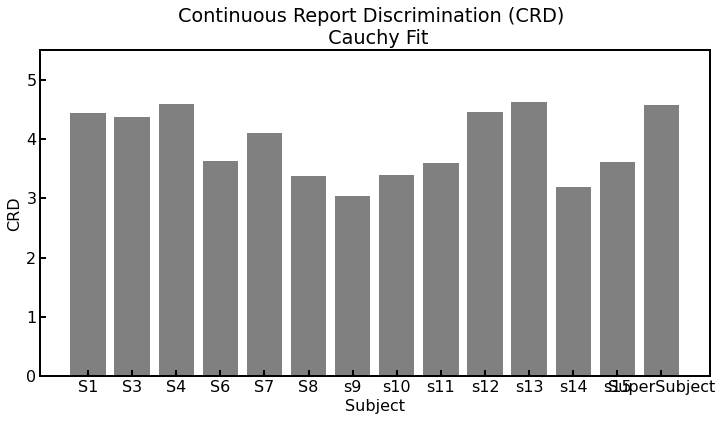

In [133]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_CAUCHY'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n Cauchy Fit')
plt.ylim([0, 5.5])

(0.0, 5.5)

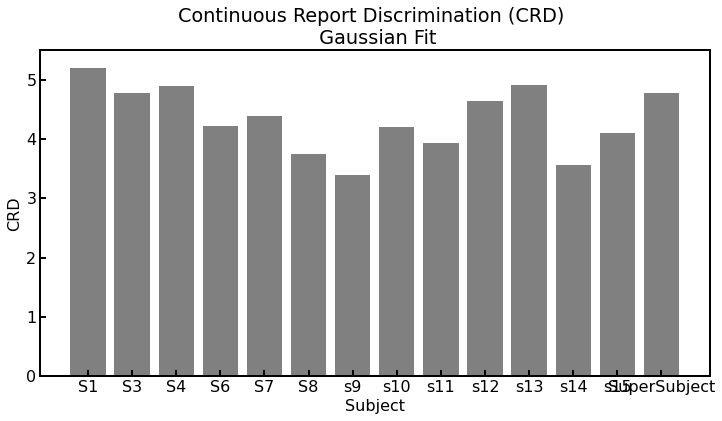

In [134]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_GAUSSIAN'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n Gaussian Fit')
plt.ylim([0, 5.5])

# Correlation slopes and JND 

In [57]:
slopes = pd.read_csv(figures_path + '/RegressionSlope_radiologists/subject_slopes.csv', index_col=0)

In [63]:
corr_df = pd.DataFrame()
row=0
for ntype in slopes.NTYPE.unique():
    
    r_value, p_value = stats.pearsonr(slopes.loc[slopes['NTYPE'] == ntype, 'BOOTSTRAP_MEAN'], cdf_data[:-1]['JND_CR'])
    corr_df.loc[row, 'NTYPE'] = ntype
    corr_df.loc[row, 'R_VALUE'] = r_value
    corr_df.loc[row, 'P_VALUE'] = p_value
    
    row+=1

In [64]:
corr_df

,NTYPE,R_VALUE,P_VALUE
0,1.0,-0.421748,0.151168
1,2.0,-0.442761,0.129734
2,3.0,0.062686,0.838789
